## Convolutional Arithmetic Notebook

### Purpose

* How does a Conv layer impact the size of output feature maps?
* How does a Conv Transpose layer impact the size of the output feature maps?
* How does padding / stride impact both of the above?

### Formulas

Normal Convolution
* W2 = (W1 - KS + 2P)/S + 1

Convolution Transpose
* W2 = S(W1 - 1) + KS - 2P

## Imports

In [1]:
import numpy as np
import os
import random
import torch
from PIL import Image
import scipy.misc
from torchvision import datasets, transforms
from torch import nn
from torch.autograd import Variable
import torch.nn.init as init
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.autograd as autograd
import torchvision
import matplotlib as mpl
from tqdm import tqdm
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('bmh')
import torchvision.utils as vutils

%matplotlib inline

## Config

In [23]:
random.seed(1)
torch.manual_seed(1)
DATA_PATH='/media/bfortuner/bigguy/data/'
CUB_PATH=DATA_PATH+'cub/'
CUB_IMAGES_PATH=CUB_PATH+'images/'
MNIST_PATH=DATA_PATH+'mnist/'
MNIST_WEIGHTS_PATH=MNIST_PATH+'weights/'
MNIST_RESULTS_PATH='results/'
CIFAR10_PATH=DATA_PATH+'cifar10/'
CIFAR10_IMGS_PATH=CIFAR10_PATH+'images/'
CIFAR10_RESULTS_PATH=CIFAR10_PATH+'results/'
CIFAR10_WEIGHTS_PATH=CIFAR10_PATH+'weights/'

## MNIST

In [123]:
MNIST_BATCH_SIZE = 128
MNIST_MEAN = np.array([0.1307,])
MNIST_STD = np.array([0.3081,])
mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(MNIST_PATH, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(MNIST_MEAN, MNIST_STD)
                   ])),
    batch_size=MNIST_BATCH_SIZE, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(MNIST_PATH, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(MNIST_MEAN, MNIST_STD)
                   ])),
    batch_size=MNIST_BATCH_SIZE*4, shuffle=True)

mnist_train_labels = mnist_train_loader.dataset.train_labels
MNIST_CLASSES = np.unique(mnist_train_labels.numpy())
print("MNIST Train Samples:", len(mnist_train_loader.dataset))
print("MNIST Test Samples:", len(mnist_test_loader.dataset))

MNIST Train Samples: 60000
MNIST Test Samples: 10000


## CIFAR10

In [208]:
CIFAR_BATCH_SIZE = 64
CIFAR_MEAN = np.array([0.49139968, 0.48215827, 0.44653124])
CIFAR_STD = np.array([0.24703233, 0.24348505, 0.26158768])
normTransform = transforms.Normalize(CIFAR_MEAN, CIFAR_STD)

trainTransform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normTransform
])
testTransform = transforms.Compose([
    transforms.ToTensor(),
    normTransform
])

cifar_train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(CIFAR10_IMGS_PATH, train=True, download=True,
                 transform=trainTransform),
    batch_size=CIFAR_BATCH_SIZE, shuffle=True)
cifar_test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(CIFAR10_IMGS_PATH, train=False, download=True,
                 transform=testTransform),
    batch_size=CIFAR_BATCH_SIZE*4, shuffle=False)

cifar_labels = cifar_train_loader.dataset.train_labels
CIFAR_CLASSES = np.unique(np.array(cifar_classes))
CIFAR_CLASS_NAMES = np.array(['airplane','automobile','bird','cat',
                          'deer','dog','frog', 'horse','ship','truck'])
print("CIFAR Train Samples:", len(cifar_train_loader.dataset))
print("CIFAR Test Samples:", len(cifar_test_loader.dataset))

Files already downloaded and verified
Files already downloaded and verified
CIFAR Train Samples: 50000
CIFAR Test Samples: 10000


## Plot Images

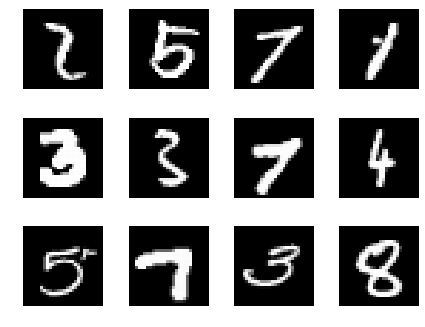

In [247]:
def imshow(inp, mean_arr, std_arr, title=None):
    """Imshow for Tensor."""
    if inp.size(0) == 1:
        inp = np.squeeze(inp.numpy())
        kwargs = {'cmap':'gray'}
    else:
        inp = inp.numpy().transpose((1, 2, 0))
        kwargs = {}
    inp = std_arr * inp + mean_arr
    plt.imshow(inp, **kwargs)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, data_loader, class_names, mean_arr, std_arr, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(data_loader):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy()
        labels = labels.data.cpu().numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('P: {}, A:{}'.format(class_names[preds[j][0]], 
                                              class_names[labels[j]]))
            imshow(inputs.cpu().data[j], mean_arr, std_arr)

            if images_so_far == num_images:
                return
        plt.tight_layout()

def plot_mnist_samples(arr, dim=(4,4), figsize=(6,6)):
    if type(arr) is not np.ndarray:
        arr = arr.numpy()
    bs = arr.shape[0]
    arr = arr.reshape(bs, 28, 28)
    plt.figure(figsize=figsize)
    for i,img in enumerate(arr):
        plt.subplot(*dim, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()

def denorm_meanstd(t, mean, std):
    return (t * std) + mean

def plot_cifar_samples(arr, dim=(4,4), figsize=(6,6)):
    if type(arr) is not np.ndarray:
        arr = arr.numpy().transpose((0, 2, 3, 1))
    arr = denorm_meanstd(arr, CIFAR_MEAN, CIFAR_STD)
    plt.figure(figsize=figsize)
    for i,img in enumerate(arr):
        plt.subplot(*dim, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    
def get_cifar_batch_of_size(bs):
    # Return batchsize smaller than 64 for testing
    inputs,targets = next(iter(cifar_test_loader))
    return inputs[:bs], targets[:bs]

def get_mnist_batch(bs):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(MNIST_PATH, train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(MNIST_MEAN, MNIST_STD)
                       ])),
        batch_size=bs, shuffle=True)
    inputs,targets = next(iter(train_loader))
    return inputs,targets

inps,targs = get_mnist_batch(12)
plot_mnist_samples(inps)

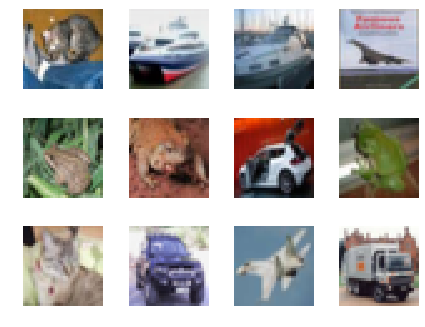

In [235]:
inputs,targets = get_cifar_batch_of_size(12)
plot_cifar_samples(inputs)

## Linear Models

In [116]:
class LinearNetMNIST(nn.Module):
    def __init__(self):
        super(LinearNetMNIST, self).__init__()
        #Let's start with an input of (bs, 784)
        self.layer1 = nn.Linear(784, 500)
        self.layer2 = nn.Linear(500, 250)
        self.layer3 = nn.Linear(250, 10)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.softmax(x)
        return x
    
class LinearNetCIFAR(nn.Module):
    def __init__(self):
        super(LinearNetCIFAR, self).__init__()
        #Let's start with an input of (bs, 3, 32, 32)
        #We flatten it to fit the first linear layer
        #(bs,32*32*3)
        self.layer1 = nn.Linear(3072, 512)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(256, 10)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = x.view(x.size(0), -1) #(bs,32*32*3)
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        x = self.softmax(x)
        return x

In [117]:
#MNIST
inputs, targets = get_mnist_batch(2)
net = LinearNetMNIST()
print(net(Variable(inputs)))

#CIFAR
inputs, targets = get_cifar_batch_of_size(2)
net2 = LinearNetCIFAR()
print(net2(Variable(inputs)))

Variable containing:
 0.1173  0.0826  0.1322  0.1040  0.0717  0.0700  0.0991  0.1430  0.0946  0.0855
 0.0947  0.0915  0.0902  0.1119  0.1058  0.1006  0.0926  0.1150  0.1077  0.0899
[torch.FloatTensor of size 2x10]

Variable containing:
 0.0950  0.1037  0.0967  0.1132  0.0965  0.0937  0.1054  0.0963  0.1005  0.0988
 0.0854  0.0947  0.1107  0.1354  0.0997  0.0756  0.1094  0.0994  0.0997  0.0900
[torch.FloatTensor of size 2x10]



## Train

In [179]:
def train(net, dataloader, criterion, optimizer, epoch=1):
    n_batches = len(dataloader)
    total_loss = 0
    for inputs,targets in dataloader:
        inputs = Variable(inputs.cuda())
        targets = Variable(targets.cuda())
        
        ## Forward Pass
        out = net(inputs)
        
        ## Clear Gradients
        net.zero_grad()
        
        ## Get Loss
        loss = criterion(out, targets)
    
        ## Backprop
        loss.backward()
        optimizer.step()
        
        total_loss += loss.data[0]
    
    return total_loss / n_batches

def predict(net, inputs):
    out = net(inputs)
    val,idx = torch.max(out,dim=1)
    return idx.data.cpu().view(-1)

def get_metrics(net, test_loader, criterion):
    data,targets = next(iter(test_loader)) #1000??
    inputs,labels = Variable(data.cuda()), Variable(targets.cuda())
    
    outputs = net(inputs)
    loss = criterion(outputs, labels).data[0]
    
    #Flatten and Get ArgMax to compute accuracy
    val,idx = torch.max(outputs,dim=1)
    predictions = idx.data.cpu().view(-1).numpy()    
    targets = targets.numpy()
    correct = np.sum(predictions==targets)
    accuracy = correct / len(targets)
    
    return loss, accuracy

### MNIST

In [169]:
N_EPOCHS = 5
mnistnet = LinearNetMNIST().cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(mnistnet.parameters(), lr=1e-4)

In [176]:
train_loss_history = []
test_loss_history = []
test_acc_history = []
for epoch in range(1, N_EPOCHS+1):
    train_loss = train(mnistnet, mnist_train_loader, criterion, optimizer, epoch)
    test_loss, test_acc = get_metrics(mnistnet, mnist_test_loader, criterion)
    print('Epoch %d, TrainLoss: %.3f, TestLoss: %.3f, TestAcc: %.3f' % (
        epoch, train_loss, test_loss, test_acc))
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

(512,) (512,)
Epoch 1, TrainLoss: 1.536, TestLoss: 1.541, TestAcc: 0.922
(512,) (512,)
Epoch 2, TrainLoss: 1.534, TestLoss: 1.547, TestAcc: 0.914
(512,) (512,)
Epoch 3, TrainLoss: 1.532, TestLoss: 1.545, TestAcc: 0.916
(512,) (512,)
Epoch 4, TrainLoss: 1.530, TestLoss: 1.533, TestAcc: 0.928
(512,) (512,)
Epoch 5, TrainLoss: 1.529, TestLoss: 1.542, TestAcc: 0.924


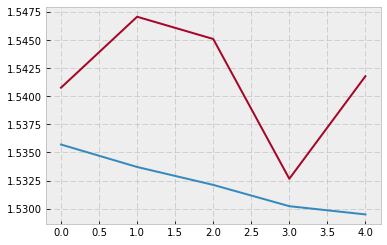

In [177]:
plt.plot(np.stack([train_loss_history, test_loss_history],1))

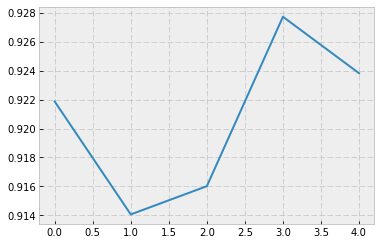

In [178]:
plt.plot(test_acc_history)

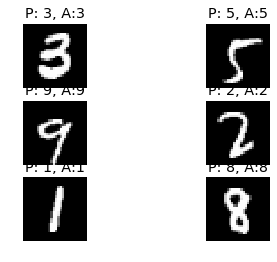

In [248]:
visualize_model(mnistnet, mnist_test_loader, MNIST_CLASSES, MNIST_MEAN, MNIST_STD, 6)

### CIFAR

In [184]:
N_EPOCHS = 50
cifarnet = LinearNetCIFAR().cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(cifarnet.parameters(), lr=1e-4)

In [ ]:
train_loss_history = []
test_loss_history = []
test_acc_history = []
for epoch in range(1, N_EPOCHS+1):
    train_loss = train(cifarnet, cifar_train_loader, criterion, optimizer, epoch)
    test_loss, test_acc = get_metrics(cifarnet, cifar_test_loader, criterion)
    print('Epoch %d, TrainLoss: %.3f, TestLoss: %.3f, TestAcc: %.3f' % (
        epoch, train_loss, test_loss, test_acc))
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

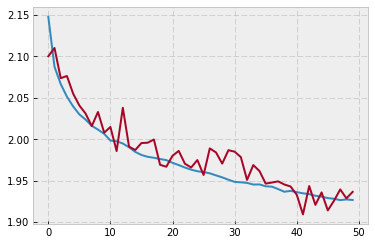

In [186]:
plt.plot(np.stack([train_loss_history, test_loss_history],1))

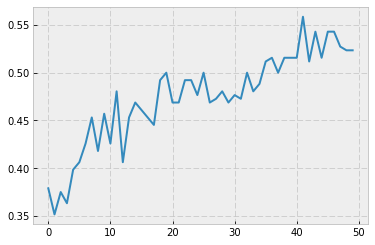

In [187]:
plt.plot(test_acc_history)

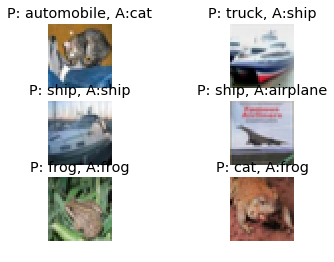

In [250]:
visualize_model(cifarnet, cifar_test_loader, CIFAR_CLASS_NAMES, CIFAR_MEAN, CIFAR_STD, 6)


 1
 9
 8
 8
 6
 3
 1
 6
 5
 1
 8
 9
[torch.LongTensor of size 12]
 
 3
 8
 8
 0
 6
 6
 1
 6
 3
 1
 0
 9
[torch.LongTensor of size 12]



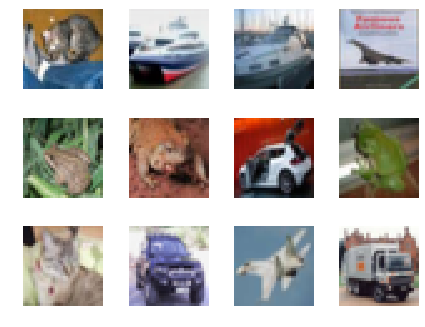

In [195]:
# View some predictions
inputs,targets = get_cifar_batch_of_size(12)
outputs = predict(cifarnet, Variable(inputs.cuda()))
plot_cifar_samples(inputs)
print(outputs.view(-1), targets)

## CNN

In [43]:
class BasicNet(nn.Module):
    def __init__(self):
        super(BasicNet, self).__init__()
        #Let's start with an input of (bs, 1, 28, 28)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=100, kernel_size=2, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=100, out_channels=10, kernel_size=2, stride=1, padding=0)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        return out

In [44]:
inputs, targets = get_mnist_batch(2)
inputs, targets = Variable(inputs.cuda()), Variable(targets.cuda())
net1 = BasicNet().cuda()

In [37]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(downNet.parameters(), lr=1e-4)

In [38]:
out = dnet1(inputs)

In [39]:
out.size()

torch.Size([2, 10, 26, 26])

## Upsampling